In [5]:
import numpy as np


from amalearn.agent import AgentBase
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import RewardBase
import matplotlib.pyplot as plt

# Part 1 - a

In [6]:
class Reward(RewardBase):
    def __init__(self, firstParameter, secondParameter, p, alpha, beta, lambdaa):
        super(Reward, self).__init__()
        self.firstParameter = firstParameter
        self.secondParameter = secondParameter
        self.p = p
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa

    def get_reward(self):
        if type(self.firstParameter) == list:
            r = np.random.uniform()
            if r <= self.p:
                mean = self.firstParameter[0]
                std = self.secondParameter[0]
                reward = np.random.normal(loc=mean, scale=std)
                utility = self.utility_function(reward)
                y = [reward, utility]
                return y
            else:
                low = self.firstParameter[1]
                high = self.secondParameter[1]
                reward  = np.random.uniform(low=low, high=high)
                utility = self.utility_function(reward)
                y = [reward, utility]
                return y

        elif type(self.firstParameter) == int:
            mean = self.firstParameter
            std = self.secondParameter
            reward = np.random.normal(loc=mean, scale=std)
            utility = self.utility_function(reward)
            y = [reward, utility]
            return y
        
    def utility_function(self, reward):
        if reward >= 0:
            u = np.power(reward, self.alpha)
        else:
            u = (-self.lambdaa) * np.power(-reward, self.beta)
            
        return u
        

In [7]:
def agent_run(agent, env, run, trial):
    mean_reward = np.zeros(trial)
    for run in range(1, run+1):
        for step in range(trial):
            obs, r, d, i = agent.take_action()
            mean_reward[step] = ((run - 1) / run) * mean_reward[step] + ( 1 / run) * r

        env.reset()
        agent.reset()

    return mean_reward 

In [8]:
def plot_mean_reward(mean_reward, lower, upper, label):
    step_no = np.arange(len(mean_reward))
    plt.figure(figsize=(16, 10))
    plt.plot(step_no, mean_reward, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    plt.ylim([lower, upper])
    new_list = range(int(np.floor(np.min(lower))), int(np.ceil(np.max(upper))+1))
    plt.yticks(new_list)
    plt.legend(fontsize='large')
    plt.show();

In [9]:
# sudent_id = 21365527
a = 7
b = 5
c = 4
d = 2
firstParameters = [b, a, c, [d, -d]]
secondParameters = [2, 1, 1, [2, 1]]

rewards = [Reward(first, second, 0.7, alpha=1, beta=1, lambdaa=1) for first, second in zip(firstParameters, secondParameters)]

## Epsilon-Greedy

In [10]:
class EpsilonGreedyBanditAgent(AgentBase):
    def __init__(self, id, environment, epsilon):
        super(EpsilonGreedyBanditAgent, self).__init__(id, environment)
        self.epsilon = epsilon
        self.available_actions = self.environment.available_actions()
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)


    def take_action(self) -> (object, float, bool, object):
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.take_best_action()

        obs, r, d, i = self.environment.step(action)
        self.update(r[1], action)

        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r[0], d, i

    def take_best_action(self):
        action = np.argmax(self.rewards_mean)
        return action

    def reset(self):
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)


    def update(self, reward, action):
        self.rewards_history[action].append(reward)
        self.rewards_mean[action] = np.mean(self.rewards_history[action])

In [62]:
env = MutliArmedBanditEnvironment(rewards, 1000, '1')
eps_greedy_gent = EpsilonGreedyBanditAgent('1', env, 0.2)

In [63]:
mean_reward = agent_run(eps_greedy_gent, env, 20, 1000)
mean_reward

array([4.41663514, 4.70676898, 4.03457495, 4.30190308, 4.80628506,
       6.05561361, 5.44610569, 4.93084027, 4.94300002, 4.75669274,
       5.08544557, 5.24388823, 5.79046821, 5.51203822, 5.53179899,
       5.42963688, 5.02022141, 6.20602554, 6.27897561, 5.6100264 ,
       5.85190917, 5.42429013, 5.50203882, 5.82092971, 5.87691859,
       5.52675146, 5.9913018 , 5.82850607, 5.38288328, 6.20334757,
       5.92884836, 5.91416205, 6.05276094, 6.33946486, 5.60885941,
       6.68323591, 5.85119351, 6.25125681, 5.84798189, 5.56310226,
       6.56403893, 6.2821618 , 6.35667102, 6.0227425 , 6.27706698,
       6.60375182, 6.09355966, 6.13046087, 6.01817424, 6.3217698 ,
       6.28843897, 6.35512913, 6.67612011, 5.89411365, 5.8875119 ,
       5.82174747, 7.15247585, 6.26627055, 6.24030561, 6.3794674 ,
       5.60947998, 5.45842677, 6.70387497, 6.29474942, 6.29608106,
       6.29084966, 6.68238726, 6.59940309, 6.33183111, 6.70744867,
       6.80363354, 6.08726193, 6.09043352, 6.58926073, 6.63026

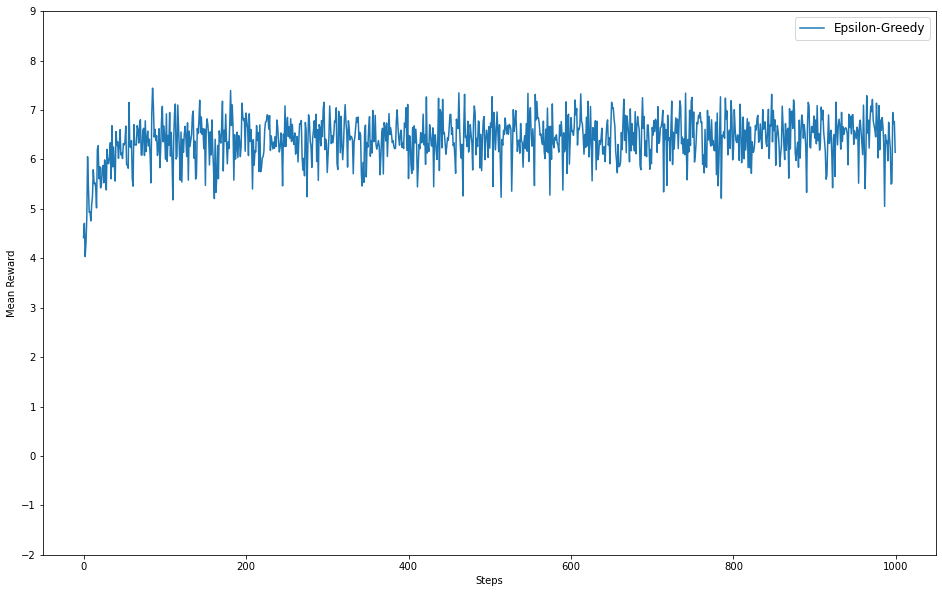

In [64]:
plot_mean_reward(mean_reward, -2, 9, 'Epsilon-Greedy')

## UCB

In [11]:
class UCBBanditAgent(AgentBase):
    def __init__(self, id, environment, confidence_level):
        super(UCBBanditAgent, self).__init__(id, environment)
        self.confidence_level = confidence_level
        self.available_actions = self.environment.available_actions()
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)
        self.actions_sum = np.zeros(self.available_actions)


    def take_action(self) -> (object, float, bool, object):
        action = self.take_best_action()
        obs, r, d, i = self.environment.step(action)
        self.update(r[1], action)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r[0], d, i

    def take_best_action(self):
        t = self.environment.state['length'] + 1
        exploitation = self.rewards_mean
        exploration = self.confidence_level * np.sqrt(np.log(t) / self.actions_sum_sanitizer())
        ucb_term = exploitation + exploration
        action = np.argmax(ucb_term)
        return action

    def reset(self):
        self.rewards_history = [[] for i in range(self.available_actions)]
        self.rewards_mean = np.zeros(self.available_actions)
        self.actions_sum = np.zeros(self.available_actions)


    def update(self, reward, action):
        self.rewards_history[action].append(reward)
        self.rewards_mean[action] = np.mean(self.rewards_history[action])
        self.actions_sum[action] += 1
        
    def actions_sum_sanitizer(self):
        eps = np.finfo(np.float32).eps
        return np.where(self.actions_sum == 0, eps, self.actions_sum)
        


In [66]:
env = MutliArmedBanditEnvironment(rewards, 1000, '2')
ucb_agent = UCBBanditAgent('2', env, 2.0)

In [67]:
mean_reward = agent_run(ucb_agent, env, 20, 1000)
mean_reward

array([4.73786627, 7.34667536, 4.27375477, 1.51873985, 6.33615381,
       6.43486969, 6.08434913, 6.8137428 , 6.70865966, 6.79598402,
       6.14836032, 6.3853038 , 6.59614309, 6.85481204, 6.66091775,
       6.50199975, 6.54822594, 6.24803521, 6.87794345, 6.83825626,
       6.90595705, 6.89630874, 6.87517443, 6.47381976, 6.50407327,
       6.67571688, 6.82445207, 6.69229836, 7.04896062, 6.78798066,
       7.04273182, 7.09908612, 6.82710649, 6.67416253, 6.82336894,
       7.09338587, 7.16594624, 7.33725043, 6.92563237, 7.1758286 ,
       6.92853655, 6.61889901, 7.00938493, 7.0682121 , 7.12535618,
       6.61350328, 7.43769153, 6.81012478, 6.86850114, 6.53154915,
       6.53583281, 7.04449381, 6.8316336 , 6.95648264, 6.84365664,
       6.59351639, 7.22565566, 6.96735997, 6.85679249, 6.97725743,
       7.67887016, 6.62467478, 6.86420752, 7.01789831, 6.68887356,
       6.97806446, 7.16365647, 6.96701933, 7.26400635, 6.77939869,
       6.84603814, 6.4576966 , 7.06228822, 7.29230459, 6.92468

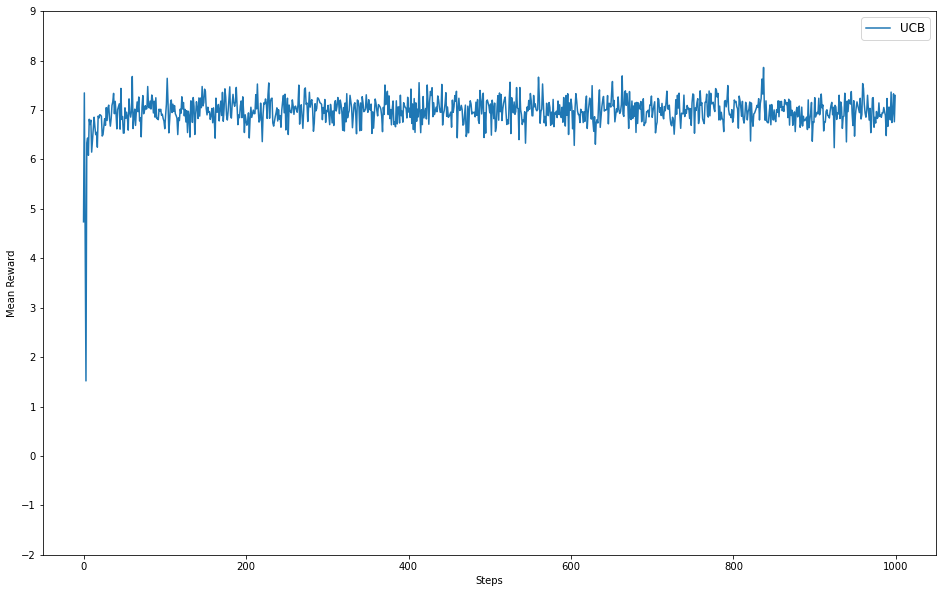

In [68]:
plot_mean_reward(mean_reward, -2, 9, 'UCB')

## Gradient

In [12]:
class GradientBanditAgent(AgentBase):
    def __init__(self, id, environment, alpha):
        super(GradientBanditAgent, self).__init__(id, environment)
        self.available_actions = self.environment.available_actions()
        self.H = np.zeros(self.available_actions)
        self.rewards = []
        self.reward_mean = 0.0
        self.alpha = alpha

       
    def take_action(self) -> (object, float, bool, object):
        probabilities = self.softmax_preferences()
        action = np.random.choice(self.available_actions, p=probabilities)
        obs, r, d, i = self.environment.step(action)
        self.update(r[1], action, probabilities)
        #print(obs, r, d, i)
        #self.environment.render()
        return obs, r[0], d, i
    
    
    def softmax_preferences(self):
        probabilities = np.exp(self.H) / np.sum(np.exp(self.H))
        return probabilities
        

    def reset(self):
        self.H = np.zeros(self.available_actions)
        self.rewards = []
        self.reward_mean = 0.0

    def update(self, current_reward, taken_action, probabilities):
  
        # update pereference        
        self.H[taken_action] = self.H[taken_action] + self.alpha * (current_reward - self.reward_mean) * (1 - probabilities[taken_action])
        not_taken_actions = self.available_actions != taken_action
        self.H[not_taken_actions] = self.H[not_taken_actions] - self.alpha * (current_reward - self.reward_mean) * (probabilities[not_taken_actions])


        # update reward mean
        self.rewards.append(current_reward)
        self.reward_mean = np.mean(self.rewards)

In [70]:
env = MutliArmedBanditEnvironment(rewards, 1000, '3')
gradient_agent = GradientBanditAgent('3', env, 0.1)

In [71]:
mean_reward = agent_run(gradient_agent, env, 20, 1000)
mean_reward

array([4.64141289, 4.35261956, 4.15988565, 3.69600937, 4.34724635,
       4.3824678 , 4.55541017, 4.02518968, 5.09607963, 5.13419386,
       4.94212417, 5.32798699, 5.03305917, 5.26607247, 5.61574188,
       5.33153954, 5.74794542, 5.14625947, 5.37446934, 5.50548592,
       6.18804871, 4.72083222, 5.28450368, 5.80974485, 5.64076949,
       6.26430871, 4.97232623, 5.90681827, 5.37692326, 5.24527906,
       6.02420472, 6.13462107, 5.54056043, 6.1134484 , 5.63234766,
       6.14679023, 6.61307594, 5.60083594, 5.73097061, 5.18950288,
       6.52516503, 5.87360585, 6.32515444, 6.00196273, 6.2329217 ,
       6.01506918, 6.66078438, 5.74370919, 5.36306714, 6.09914792,
       5.2819082 , 6.10317005, 6.071043  , 6.58655461, 6.54926276,
       6.06660438, 5.1211048 , 6.29102278, 6.84141167, 6.77347078,
       6.44017054, 5.69396247, 6.68403944, 5.8610952 , 6.73009889,
       5.93786845, 5.98611572, 6.01324073, 5.52504928, 5.96700475,
       5.3391968 , 5.67972349, 6.83318289, 5.76441053, 5.99876

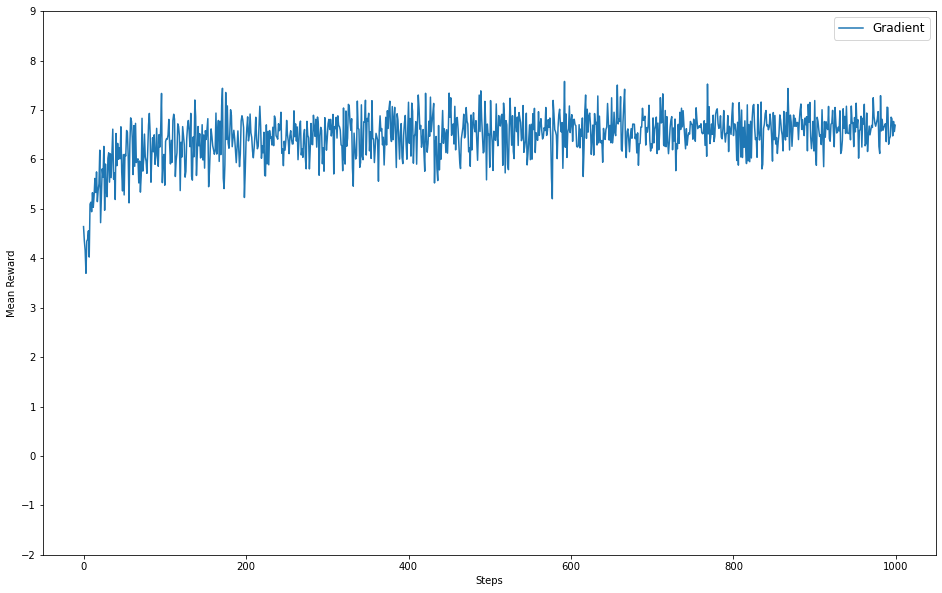

In [72]:
plot_mean_reward(mean_reward, -2, 9, 'Gradient')

In [15]:
def mean_reward_diff_agent(agentTypes):
    mr_list = []
    labels = []
    for agentType in agentTypes:

        env = MutliArmedBanditEnvironment(rewards, 1000, '4')
        
        if agentType == 'Epsilon-Greedy':
            eps_greedy_agent = EpsilonGreedyBanditAgent('4', env, 0.2)
            mr = agent_run(eps_greedy_agent, env, 20, 1000)
            
        elif agentType == 'UCB':
            ucb_agent = UCBBanditAgent('4', env, 2.0)
            mr = agent_run(ucb_agent, env, 20, 1000)

        
        elif agentType == 'Gradient':
            gradient_agent = GradientBanditAgent('4', env, 0.1)
            mr = agent_run(gradient_agent, env, 20, 1000)

            
        mr_list.append(mr)
        labels.append(agentType)
        
    return mr_list, labels

In [21]:
def plot_mean_reward_diff_agent(mr_list, labels, lower, upper):
    step_no = np.arange(len(mr_list[0]))
    plt.figure(figsize=(17, 12))

    
    for i, mr in enumerate(mr_list):
        plt.plot(step_no, mr, label=labels[i])
        
    plt.xlabel("Steps")
    plt.ylabel("Mean Reward")
    plt.ylim([lower, upper])
    new_list = range(int(np.floor(np.min(lower))), int(np.ceil(np.max(upper))+1))
    plt.yticks(new_list)
    plt.legend(fontsize='large')
    plt.show();

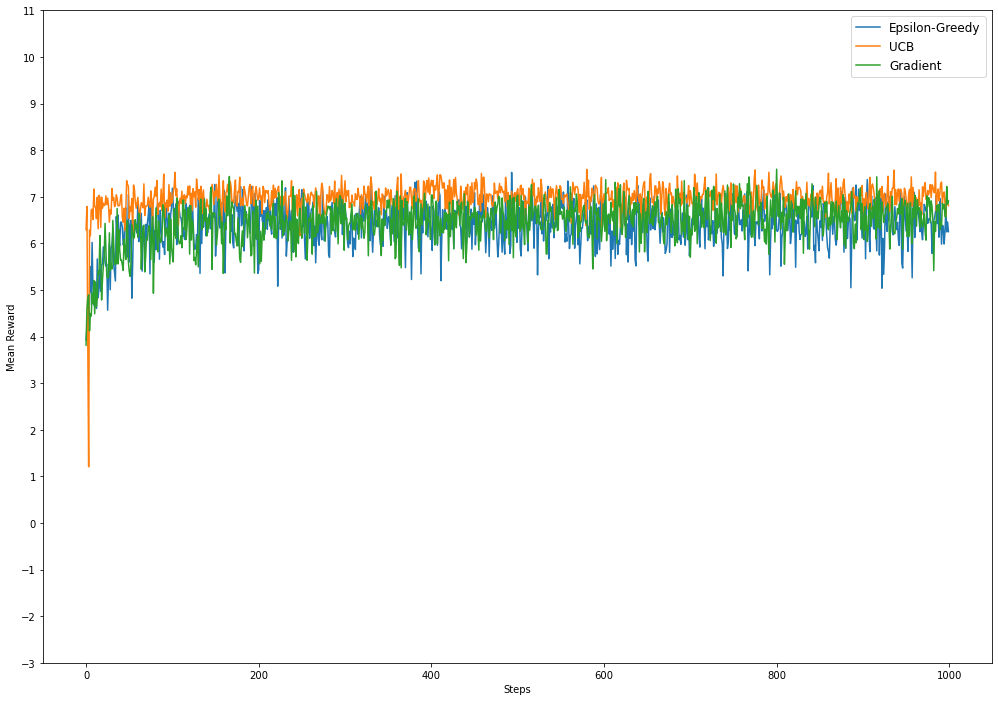

In [22]:
agentTypes = ['Epsilon-Greedy', 'UCB', 'Gradient']
mr_list, labels = mean_reward_diff_agent(agentTypes)
plot_mean_reward_diff_agent(mr_list, labels, -3, 11)

# Part 1 - b

In [19]:
def cumulative_mean_reward(mean_reward):
    cmr = np.zeros(len(mean_reward))
    
    for i in range(len(mean_reward)):
        cmr[i] = np.mean(mean_reward[:i+1])
    
    return cmr

In [20]:
def mean_reward_diff_uparam(utility_parameters, agentType):
    mr_list = []
    cmr_list = []
    labels = []
    for parameter in utility_parameters:
        rewards = [Reward(first, second, 0.7, alpha=parameter[0], beta=parameter[1], lambdaa=parameter[2]) \
                   for first, second in zip(firstParameters, secondParameters)]
        env = MutliArmedBanditEnvironment(rewards, 1000, '2')
        
        if agentType == 'eps-greedy':
            eps_greedy_agent = EpsilonGreedyBanditAgent('2', env, 0.2)
            mr = agent_run(eps_greedy_agent, env, 20, 1000)
            cmr = cumulative_mean_reward(mr)
            
        elif agentType == 'ucb':
            ucb_agent = UCBBanditAgent('2', env, 2.0)
            mr = agent_run(ucb_agent, env, 20, 1000)
            cmr = cumulative_mean_reward(mr)

        
        elif agentType == 'gradient':
            gradient_agent = GradientBanditAgent('2', env, 0.1)
            mr = agent_run(gradient_agent, env, 20, 1000)
            cmr = cumulative_mean_reward(mr)

            
        mr_list.append(mr)
        cmr_list.append(cmr)
        labels.append('alpha: ' + str(parameter[0]) + ', beta: ' + str(parameter[1]) + ', lambda: ' + str(parameter[2]))
        
    return mr_list, cmr_list, labels

In [21]:
def plot_mean_reward_diff_uparam(mr_list, labels, agentType, lower, upper):
    step_no = np.arange(len(mr_list[0]))
    plt.figure(figsize=(17, 11))

    
    for i, mr in enumerate(mr_list):
        plt.plot(step_no, mr, label=labels[i])
        plt.title(agentType)
        
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Mean Reward")
    plt.ylim([lower, upper])
    plt.legend()
    plt.show();

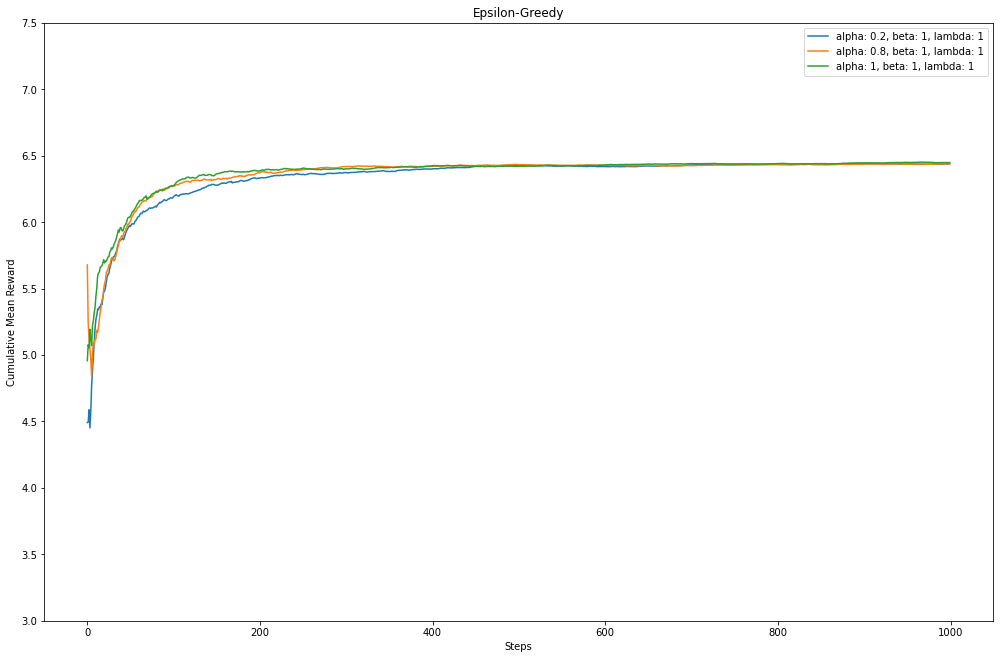

In [23]:
u_param = [[0.2,1,1],[0.8,1,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'eps-greedy')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Epsilon-Greedy', 3, 7.5)

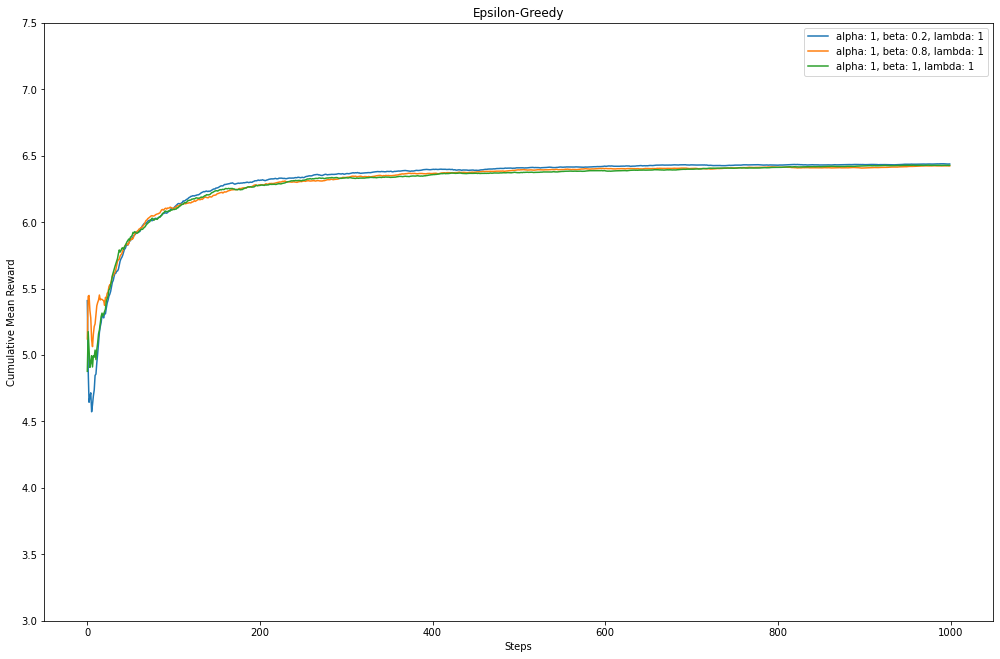

In [24]:
u_param = [[1,0.2,1],[1,0.8,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'eps-greedy')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Epsilon-Greedy', 3, 7.5)

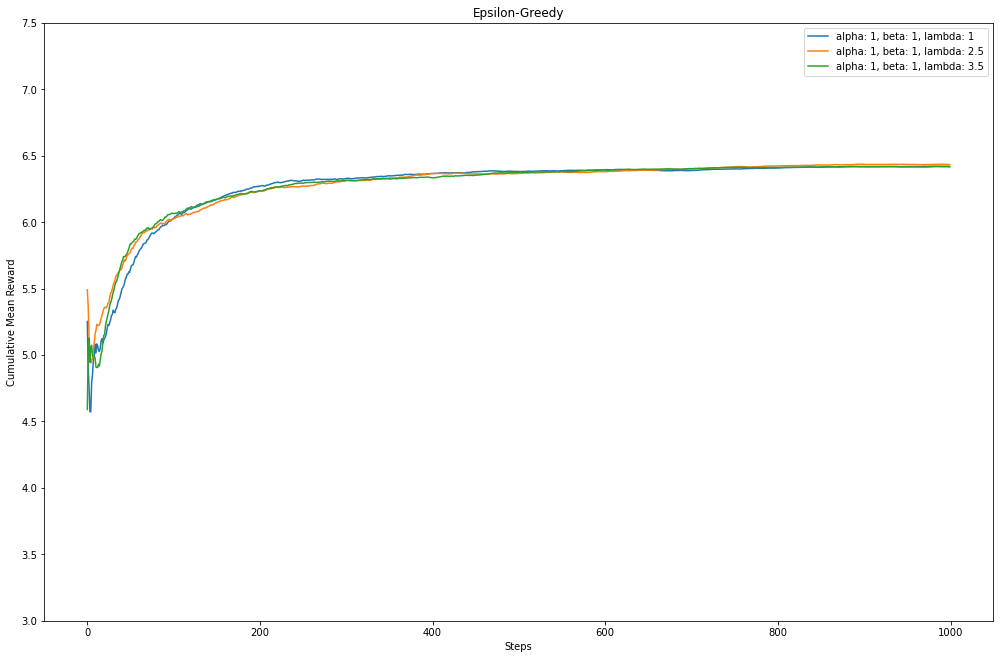

In [25]:
u_param = [[1,1,1],[1, 1,2.5],[1,1,3.5]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'eps-greedy')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Epsilon-Greedy', 3, 7.5)

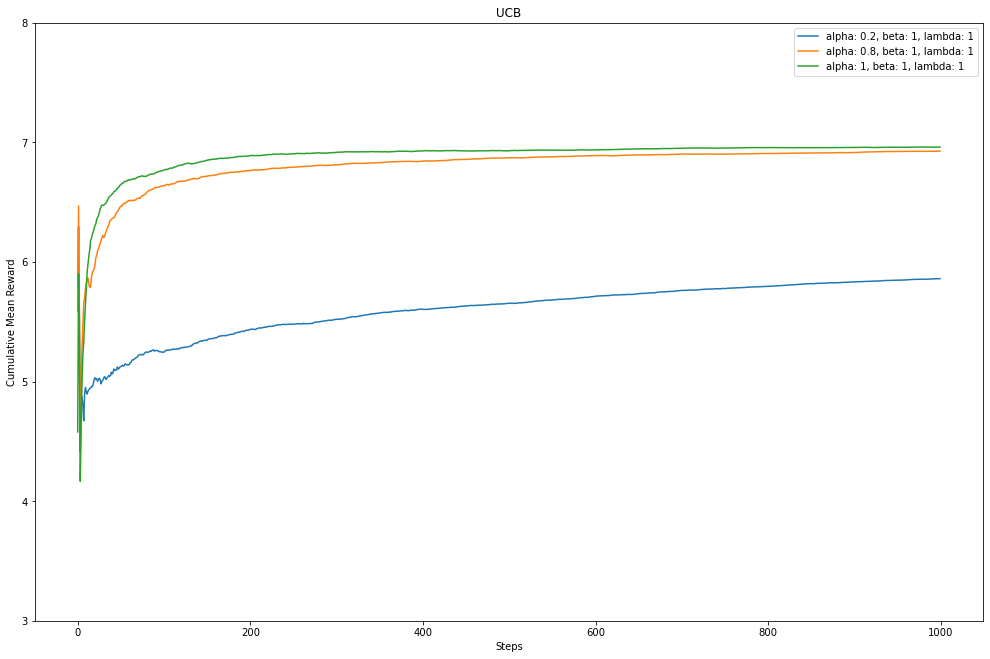

In [26]:
u_param = [[0.2,1,1],[0.8,1,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'ucb')
plot_mean_reward_diff_uparam(cmr_list, labels, 'UCB', 3, 8)

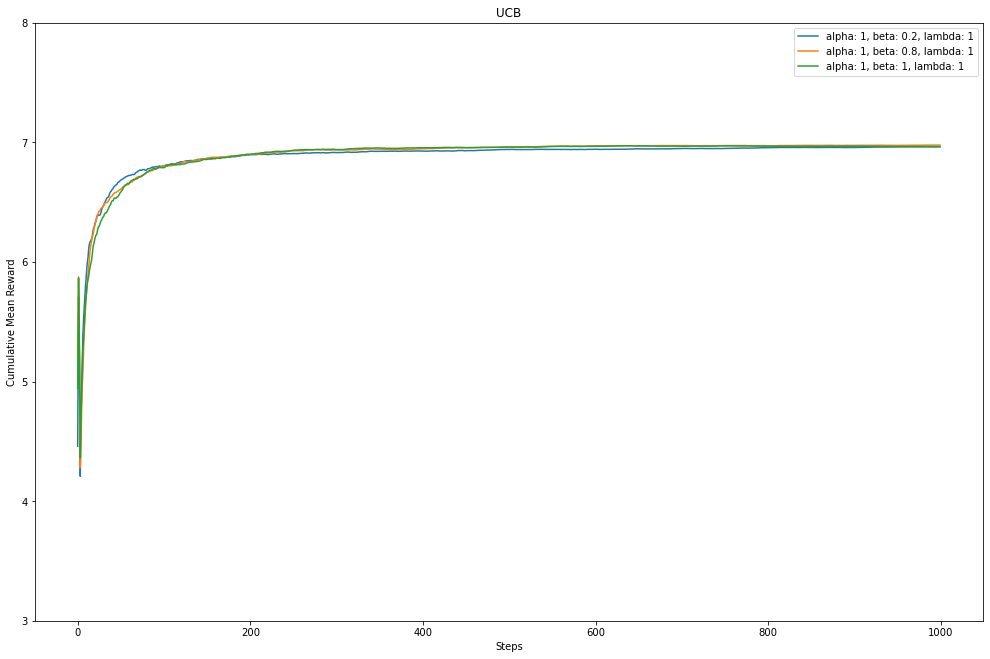

In [27]:
u_param = [[1,0.2,1],[1,0.8,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'ucb')
plot_mean_reward_diff_uparam(cmr_list, labels, 'UCB', 3, 8)

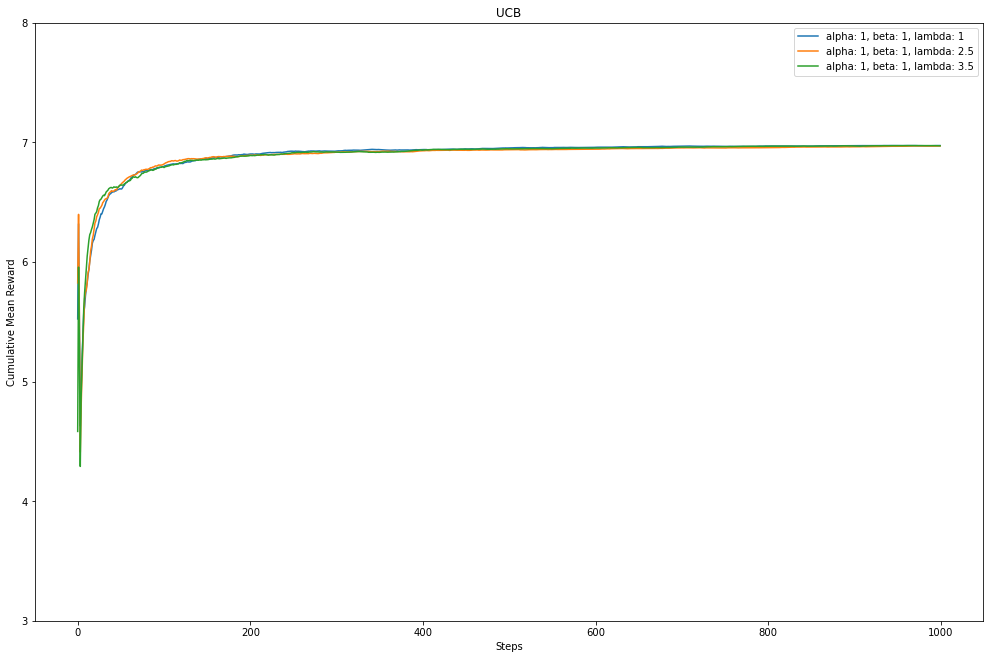

In [28]:
u_param = [[1,1,1],[1,1,2.5],[1,1,3.5]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'ucb')
plot_mean_reward_diff_uparam(cmr_list, labels, 'UCB', 3, 8)

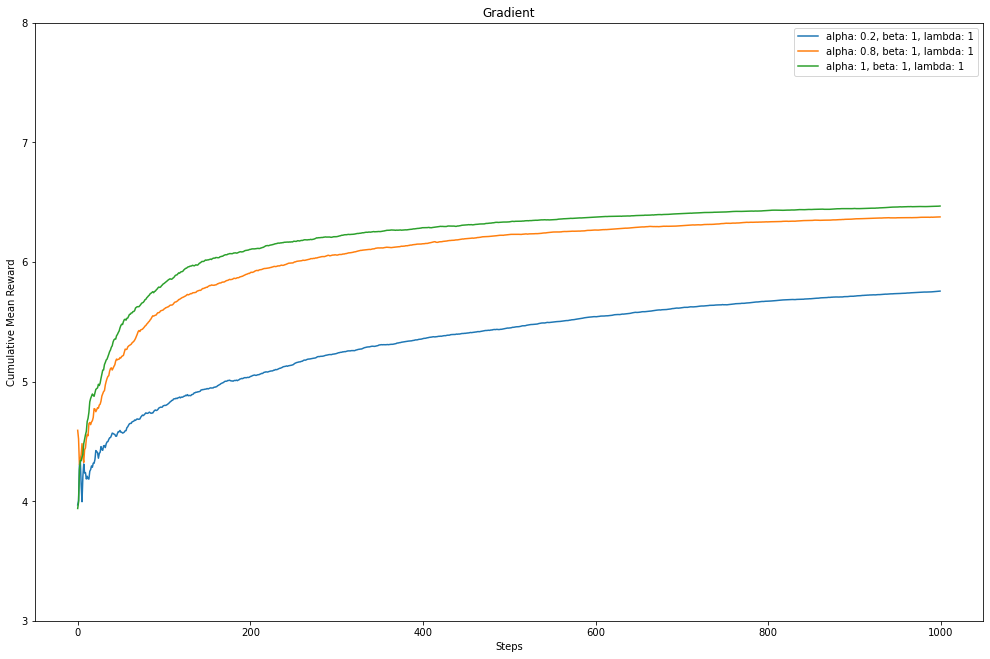

In [29]:
u_param = [[0.2,1,1],[0.8,1,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'gradient')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Gradient', 3, 8)

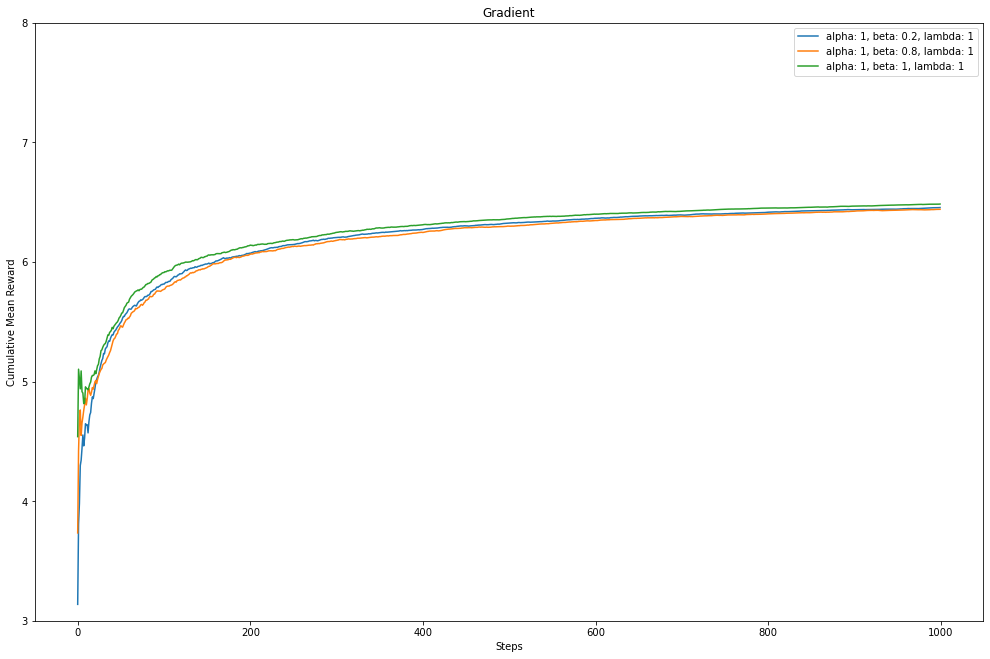

In [30]:
u_param = [[1,0.2,1],[1,0.8,1],[1,1,1]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'gradient')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Gradient', 3, 8)

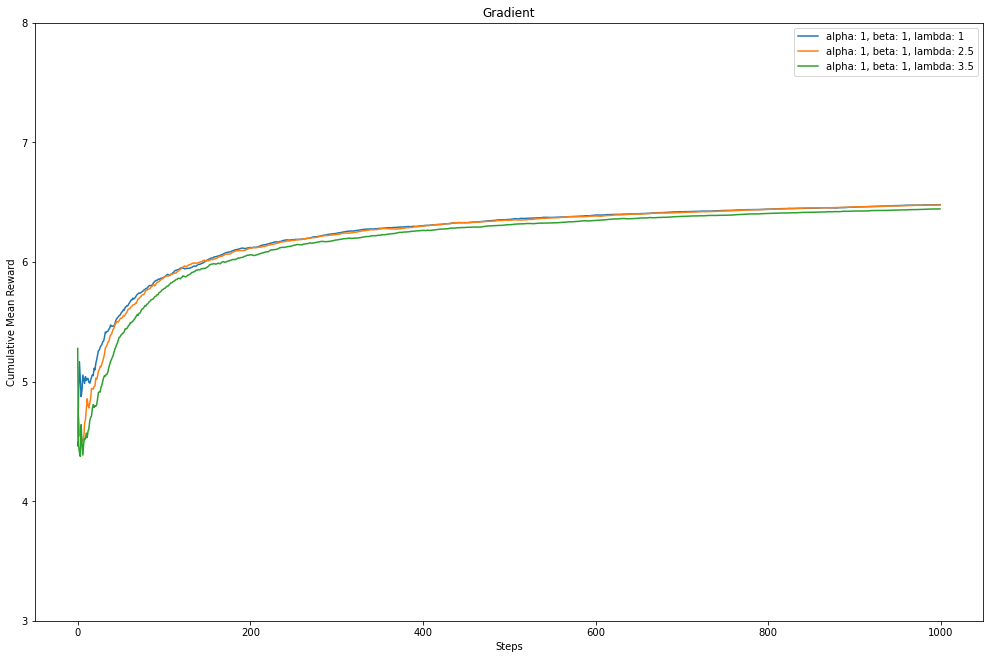

In [31]:
u_param = [[1,1,1],[1, 1, 2.5],[1, 1, 3.5]]
mr_list, cmr_list, labels = mean_reward_diff_uparam(u_param, 'gradient')
plot_mean_reward_diff_uparam(cmr_list, labels, 'Gradient', 3, 8)

# Part 2 - a

## Decaying-epsilon-greedy

In [32]:
class DecayingEpsilonGreedyBanditAgent(EpsilonGreedyBanditAgent):
    def __init__(self, id, environment, epsilon):
        super(DecayingEpsilonGreedyBanditAgent, self).__init__(id, environment, epsilon)
        self.initial_epsilon = epsilon

    def update(self, reward, action):
        self.rewards_history[action].append(reward)
        self.rewards_mean[action] = np.mean(self.rewards_history[action])
        t = self.environment.state['length']
        self.epsilon = self.initial_epsilon * np.exp(-t/100)
        
    def get_epsilon_value(self):
        return self.epsilon

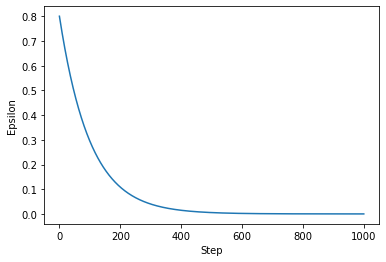

In [33]:
env = MutliArmedBanditEnvironment(rewards, 1000, '4')
decaying_eps_greedy_agent = DecayingEpsilonGreedyBanditAgent('4', env, 0.8)
trials = 1000
epsilons = np.zeros(trials)

for step in range(trials):
    epsilons[step] = decaying_eps_greedy_agent.get_epsilon_value()
    obs, r, d, i = decaying_eps_greedy_agent.take_action()

step_no = np.arange(trials)
plt.plot(step_no, epsilons)
plt.xlabel("Step")
plt.ylabel("Epsilon")
plt.show();

In [41]:
def mean_reward_diff_eps(epsilons):
    mr_list = []
    labels = []
    
    for key, value in epsilons.items():
        if key == "eps-greedy":
            for epsilon in value:
                env = MutliArmedBanditEnvironment(rewards, 1000, '4')
                eps_greedy_agent = EpsilonGreedyBanditAgent('4', env, epsilon)
                mr = agent_run(eps_greedy_agent, env, 20, 1000)
                mr_list.append(mr)
                labels.append(key + ':  ' + str(epsilon))
            
        elif key == "decaying-eps-greedy":
            for epsilon in value:
                env = MutliArmedBanditEnvironment(rewards, 1000, '4')
                decaying_eps_greedy_agent = DecayingEpsilonGreedyBanditAgent('4', env, epsilon)
                mr = agent_run(decaying_eps_greedy_agent, env, 20, 1000)
                mr_list.append(mr)
                labels.append(key + ':  ' + str(epsilon))
            
       
    return mr_list, labels

In [42]:
def plot_mean_reward_diff_eps(mr_list, labels, lower, upper):
    step_no = np.arange(len(mr_list[0]))
    plt.figure(figsize=(20, 10))
        
    for i, mr in enumerate(mr_list):
        plt.plot(step_no, mr, label=labels[i])
    

    plt.xlabel("Step")
    plt.ylabel("Mean Reward")
    plt.ylim([lower, upper])
    new_list = range(int(np.floor(np.min(lower))), int(np.ceil(np.max(upper))+1))
    plt.yticks(new_list)
    plt.legend()
    plt.show();

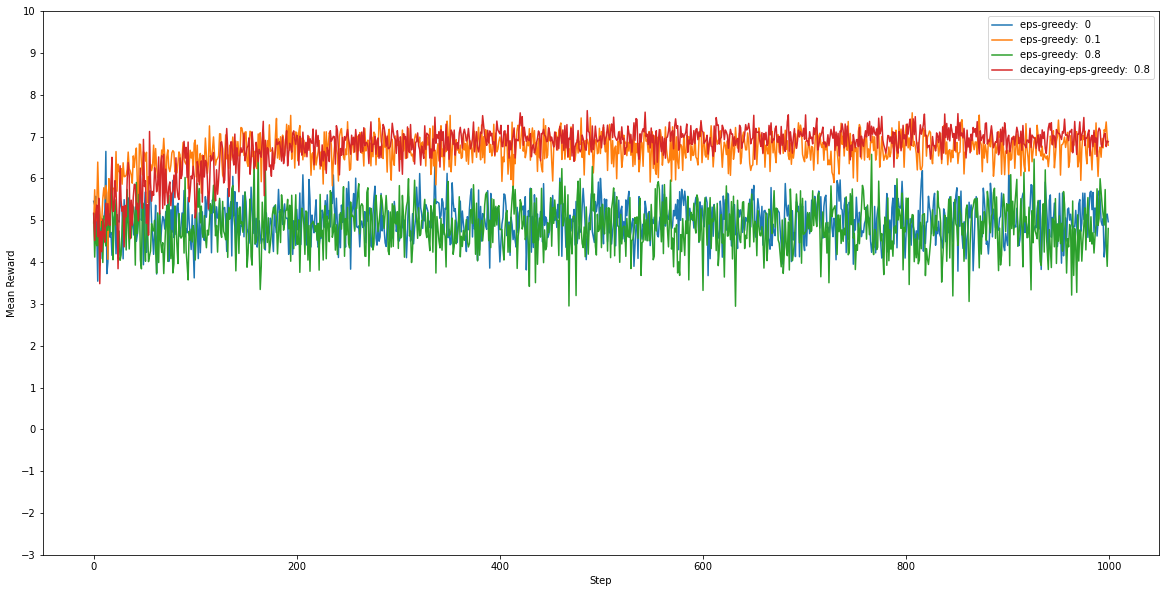

In [44]:
epsilons = {"eps-greedy":[0, 0.1, 0.8],
            "decaying-eps-greedy":[0.8]}


mr_list, labels = mean_reward_diff_eps(epsilons)
plot_mean_reward_diff_eps(mr_list, labels, -3, 10)